# Solar vs GLM LayerNorm Analysis

모든 Figure 생성을 위한 통합 노트북

## 0. Setup

In [1]:
!pip install numpy matplotlib huggingface_hub safetensors torch scikit-learn

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from huggingface_hub import hf_hub_download
from safetensors import safe_open
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 9,
    'axes.titlesize': 10,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 7,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
})

In [3]:
MODELS = {
    'Solar': 'upstage/Solar-Open-100B',
    'GLM': 'zai-org/GLM-4.5-Air',
    'INTELLECT': 'PrimeIntellect/INTELLECT-3',
    'Phi': 'microsoft/Phi-3.5-MoE-instruct',
}

COLORS = {
    'Solar': '#8B7FC7',
    'GLM': '#3d3d3d',
    'INTELLECT': '#7a7a7a',
    'Phi': '#2ca02c',
}

MARKERS = {
    'Solar': 'o',
    'GLM': 's',
    'INTELLECT': '^',
    'Phi': 'D',
}

In [4]:
       
weight_cache = {}

def load_layernorm_weight(model_id: str, layer_idx: int, norm_type: str = "input"):
    cache_key = (model_id, layer_idx, norm_type)
    if cache_key in weight_cache:
        return weight_cache[cache_key]
    try:
        index_file = hf_hub_download(repo_id=model_id, filename="model.safetensors.index.json")
        with open(index_file) as f:
            index = json.load(f)
        if norm_type == "input":
            key = f"model.layers.{layer_idx}.input_layernorm.weight"
        else:
            key = f"model.layers.{layer_idx}.post_attention_layernorm.weight"
        if key not in index["weight_map"]:
            return None
        shard_name = index["weight_map"][key]
        shard_file = hf_hub_download(repo_id=model_id, filename=shard_name)
        with safe_open(shard_file, framework="pt") as f:
            if key in f.keys():
                w = f.get_tensor(key).float().numpy()
                weight_cache[cache_key] = w
                return w
    except Exception:
        pass
    return None

def load_all_layers(model_id: str, norm_type: str, max_layer: int = 46):
    weights = []
    for layer_idx in range(max_layer + 1):
        w = load_layernorm_weight(model_id, layer_idx, norm_type)
        if w is not None:
            weights.append(w)
    if weights:
        return np.array(weights)
    return None

def raw_cosine(a, b):
    a, b = a.flatten(), b.flatten()
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def pearson_correlation(a, b):
    a, b = a.flatten(), b.flatten()
    a_c, b_c = a - a.mean(), b - b.mean()
    denom = np.linalg.norm(a_c) * np.linalg.norm(b_c)
    if denom == 0:
        return 1.0 if np.allclose(a_c, b_c) else 0.0
    return np.dot(a_c, b_c) / denom

In [ ]:
                                   
for name, model_id in MODELS.items():
    config_file = hf_hub_download(repo_id=model_id, filename="config.json")
    with open(config_file) as f:
        config = json.load(f)
    
    expected_layers = config.get("num_hidden_layers", "N/A")
    expected_dim = config.get("hidden_size", "N/A")
    
    loaded = load_all_layers(model_id, "input", max_layer=100)
    actual_layers = len(loaded) if loaded is not None else 0
    actual_dim = loaded[0].shape[0] if loaded is not None else 0
    
    match = "OK" if (actual_layers == expected_layers and actual_dim == expected_dim) else "MISMATCH"
    print(f"[{match:8}] {name:12} | config: {expected_layers} layers x {expected_dim} dim | loaded: {actual_layers} layers x {actual_dim} dim")

                  
                                                                                       
                                                                                       
                                                                                       
                                                                                       
                                                             

## 1. Figure 1, 3, 4: Intuition Bar Charts

In [6]:
def generate_comparison(model_a, model_b, title_prefix):
    model_a_id = MODELS[model_a]
    model_b_id = MODELS[model_b]

    all_cos, all_pear, valid_layers = [], [], []
    for layer_idx in range(47):
        wa = load_layernorm_weight(model_a_id, layer_idx, "input")
        wb = load_layernorm_weight(model_b_id, layer_idx, "input")
        if wa is not None and wb is not None and wa.shape == wb.shape:
            all_cos.append(raw_cosine(wa, wb))
            all_pear.append(pearson_correlation(wa, wb))
            valid_layers.append(layer_idx)

    if not valid_layers:
        return

    best_idx = np.argmax(all_cos)
    best_layer = valid_layers[best_idx]
    wa = load_layernorm_weight(model_a_id, best_layer, "input")
    wb = load_layernorm_weight(model_b_id, best_layer, "input")

    n_samples = 50
    combined = (wa + wb) / 2
    quartiles = np.percentile(combined, [0, 25, 50, 75, 100])
    sampled_indices = []
    np.random.seed(42)
    for i in range(4):
        mask = (combined >= quartiles[i]) & (combined <= quartiles[i+1])
        indices_in_quartile = np.where(mask)[0]
        n_from_quartile = n_samples // 4 + (1 if i < n_samples % 4 else 0)
        sampled = np.random.choice(indices_in_quartile, min(n_from_quartile, len(indices_in_quartile)), replace=False)
        sampled_indices.extend(sampled)
    sampled_indices = sorted(sampled_indices[:n_samples])

    wa_sampled, wb_sampled = wa[sampled_indices], wb[sampled_indices]
    cos_val, pear_val = raw_cosine(wa, wb), pearson_correlation(wa, wb)

    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
    x = np.arange(len(sampled_indices))
    width = 0.35

    ax1 = axes[0]
    ax1.bar(x - width/2, wa_sampled, width, label=model_a, color=COLORS[model_a], alpha=0.8)
    ax1.bar(x + width/2, wb_sampled, width, label=model_b, color=COLORS[model_b], alpha=0.8)
    ax1.axhline(y=1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Init (1.0)')
    ax1.set_xlabel('Sampled Dimension')
    ax1.set_ylabel('γ value')
    ax1.set_xticks([])
    ax1.text(-0.12, 1.05, '(a)', transform=ax1.transAxes, fontsize=11, fontweight='bold')
    ax1.text(0.02, 0.98, f'cos = {cos_val:.2f}', transform=ax1.transAxes, ha='left', va='top', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', linewidth=0.5))
    ax1.set_title(f'Layer {best_layer}', fontsize=10, fontweight='bold', pad=8)
    ax1.legend(loc='upper right', frameon=True, facecolor='white', fontsize=7)

    ax2 = axes[1]
    wa_centered, wb_centered = wa_sampled - wa_sampled.mean(), wb_sampled - wb_sampled.mean()
    ax2.bar(x - width/2, wa_centered, width, label=model_a, color=COLORS[model_a], alpha=0.8)
    ax2.bar(x + width/2, wb_centered, width, label=model_b, color=COLORS[model_b], alpha=0.8)
    ax2.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    ax2.set_xlabel('Sampled Dimension')
    ax2.set_ylabel('γ - mean(self)')
    ax2.set_xticks([])
    ax2.text(-0.12, 1.05, '(b)', transform=ax2.transAxes, fontsize=11, fontweight='bold')
    ax2.text(0.02, 0.98, f'r = {pear_val:.2f}', transform=ax2.transAxes, ha='left', va='top', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', linewidth=0.5))
    ax2.set_title('Centered', fontsize=10, fontweight='bold', pad=8)
    ax2.legend(loc='upper right', frameon=True, facecolor='white', fontsize=7)

    ax3 = axes[2]
    ax3.plot(valid_layers, all_cos, '-o', color='#5a5a5a', label='Raw Cosine', markersize=3, linewidth=1.5)
    ax3.plot(valid_layers, all_pear, '-^', color='#8B7FC7', label='Pearson', markersize=3, linewidth=1.5)
    ax3.axvline(x=best_layer, color='red', linestyle=':', linewidth=1, alpha=0.7)
    ax3.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax3.set_xlabel('Layer')
    ax3.set_ylabel('Similarity')
    ax3.text(-0.12, 1.05, '(c)', transform=ax3.transAxes, fontsize=11, fontweight='bold')
    ax3.set_title('Per-Layer', fontsize=10, fontweight='bold', pad=8)
    ax3.legend(loc='center right', frameon=True, facecolor='white', fontsize=7)
    ax3.set_ylim(-0.2, 1.1)
    ax3.grid(True, alpha=0.3)

    fig.suptitle(f'{title_prefix}: {model_a} vs {model_b}', fontsize=12, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

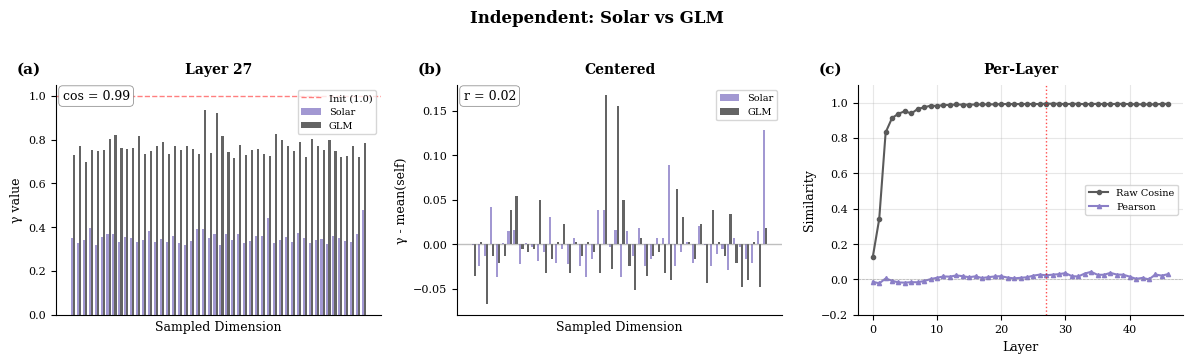

In [7]:
                                      
pairs = [('Solar', 'GLM', 'Independent')]
for model_a, model_b, title_prefix in pairs:
    generate_comparison(model_a, model_b, title_prefix)


## 2. Figure 2: Solar vs GLM Heatmap

In [8]:
n_layers = 47

solar_weights = [load_layernorm_weight(MODELS['Solar'], layer, "input") for layer in range(n_layers)]
glm_weights = [load_layernorm_weight(MODELS['GLM'], layer, "input") for layer in range(n_layers)]

cosine_matrix = np.full((n_layers, n_layers), np.nan)
pearson_matrix = np.full((n_layers, n_layers), np.nan)

for i in range(n_layers):
    for j in range(n_layers):
        if solar_weights[i] is not None and glm_weights[j] is not None:
            if solar_weights[i].shape == glm_weights[j].shape:
                cosine_matrix[i, j] = raw_cosine(solar_weights[i], glm_weights[j])
                pearson_matrix[i, j] = pearson_correlation(solar_weights[i], glm_weights[j])

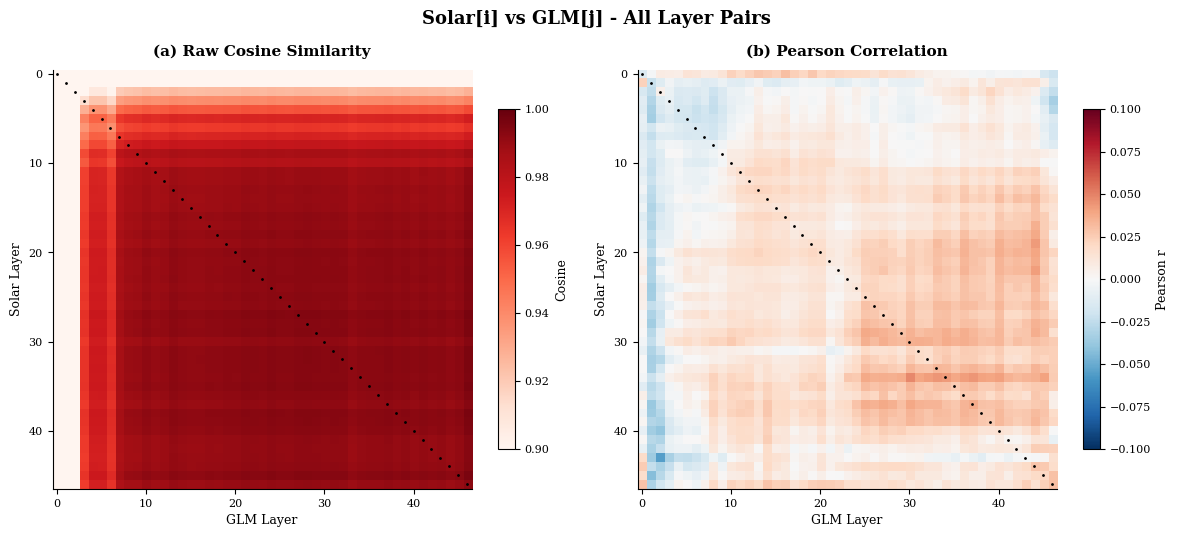

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
im1 = ax1.imshow(cosine_matrix, cmap='Reds', aspect='equal', vmin=0.9, vmax=1.0)
ax1.set_xlabel('GLM Layer')
ax1.set_ylabel('Solar Layer')
ax1.set_title('(a) Raw Cosine Similarity', fontsize=11, fontweight='bold', pad=10)
plt.colorbar(im1, ax=ax1, shrink=0.8).set_label('Cosine')
for i in range(n_layers):
    ax1.plot(i, i, 'k.', markersize=2)

ax2 = axes[1]
im2 = ax2.imshow(pearson_matrix, cmap='RdBu_r', aspect='equal', vmin=-0.1, vmax=0.1)
ax2.set_xlabel('GLM Layer')
ax2.set_ylabel('Solar Layer')
ax2.set_title('(b) Pearson Correlation', fontsize=11, fontweight='bold', pad=10)
plt.colorbar(im2, ax=ax2, shrink=0.8).set_label('Pearson r')
for i in range(n_layers):
    ax2.plot(i, i, 'k.', markersize=2)

fig.suptitle('Solar[i] vs GLM[j] - All Layer Pairs', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

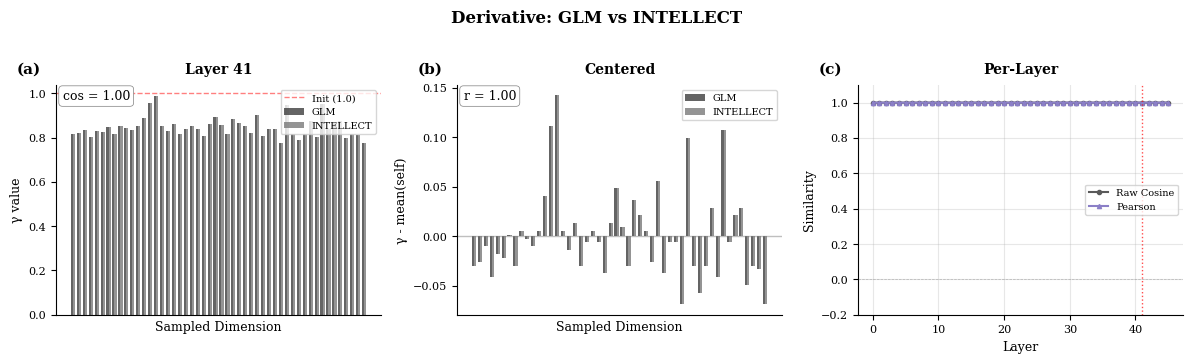

In [10]:
                                         
pairs = [('GLM', 'INTELLECT', 'Derivative')]
for model_a, model_b, title_prefix in pairs:
    generate_comparison(model_a, model_b, title_prefix)


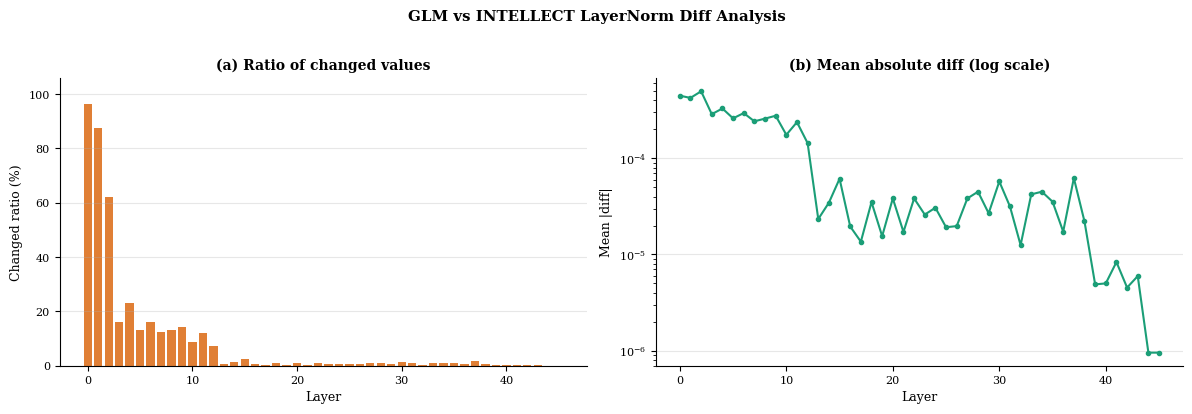

In [11]:
                                                     
glm_id = MODELS['GLM']
intellect_id = MODELS['INTELLECT']
max_layer = 46

layer_indices = []
changed_ratio = []
mean_abs_diff = []

for layer in range(max_layer + 1):
    glm_w = load_layernorm_weight(glm_id, layer, "input")
    intel_w = load_layernorm_weight(intellect_id, layer, "input")
    if glm_w is None or intel_w is None:
        continue
    if glm_w.shape != intel_w.shape:
        continue
    
                                          
    diff_ratio = (glm_w != intel_w).mean() * 100.0
    mean_diff = np.abs(glm_w - intel_w).mean()
    
    layer_indices.append(layer)
    changed_ratio.append(diff_ratio)
    mean_abs_diff.append(mean_diff)

if layer_indices:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1 = axes[0]
    ax1.bar(layer_indices, changed_ratio, color='#d95f02', alpha=0.8)
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Changed ratio (%)')
    ax1.set_title('(a) Ratio of changed values', fontweight='bold')
    ax1.set_ylim(0, max(changed_ratio) * 1.1 if changed_ratio else 1)
    ax1.grid(True, axis='y', alpha=0.3)
    
    ax2 = axes[1]
    ax2.plot(layer_indices, mean_abs_diff, '-o', color='#1b9e77', markersize=3, linewidth=1.5)
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Mean |diff|')
    ax2.set_title('(b) Mean absolute diff (log scale)', fontweight='bold')
    ax2.set_yscale('log')
    ax2.grid(True, axis='y', alpha=0.3)
    
    fig.suptitle('GLM vs INTELLECT LayerNorm Diff Analysis', fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No comparable layers found for GLM and INTELLECT.")

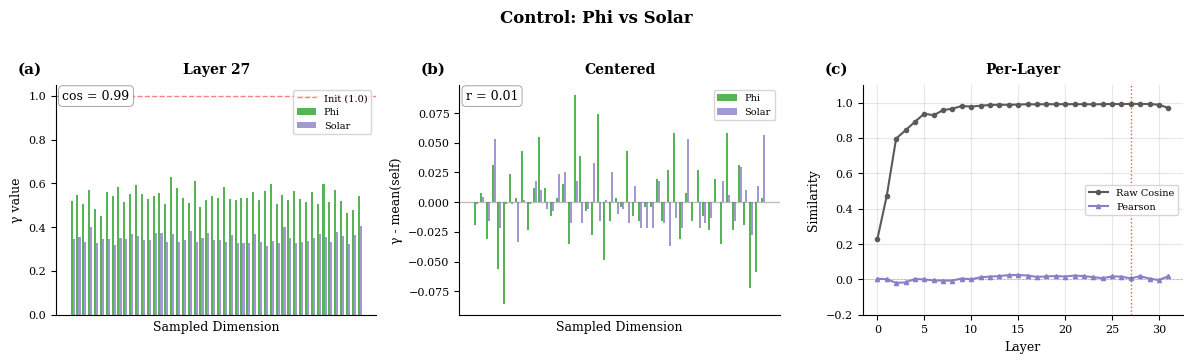

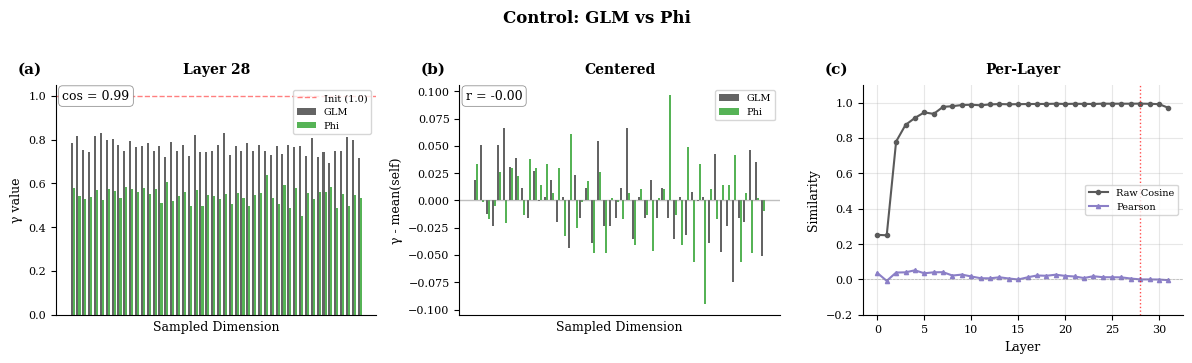

In [12]:
                    
pairs = [('Phi', 'Solar', 'Control'), ('GLM', 'Phi', 'Control')]
for model_a, model_b, title_prefix in pairs:
    generate_comparison(model_a, model_b, title_prefix)


## 3. Figure 5: Multi-pair Heatmaps

In [13]:
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) / 255 for i in (0, 2, 4))

def create_pair_colormap(model_a, model_b, is_derivative=False):
    color_a = hex_to_rgb(COLORS[model_a])
    color_b = hex_to_rgb(COLORS[model_b])
    blend = tuple((a + b) / 2 for a, b in zip(color_a, color_b))
    if is_derivative:
        return LinearSegmentedColormap.from_list(f'{model_a}_{model_b}', ['white', blend, blend], N=256)
    else:
        light_blend = tuple(0.3 + 0.7 * c for c in blend)
        return LinearSegmentedColormap.from_list(f'{model_a}_{model_b}', [light_blend, 'white', light_blend], N=256)

def compute_pairwise_matrix(weights_a, weights_b):
    n_a, n_b = len(weights_a), len(weights_b)
    matrix = np.full((n_a, n_b), np.nan)
    for i in range(n_a):
        for j in range(n_b):
            if weights_a[i] is not None and weights_b[j] is not None:
                min_dim = min(len(weights_a[i]), len(weights_b[j]))
                matrix[i, j] = pearson_correlation(weights_a[i][:min_dim], weights_b[j][:min_dim])
    return matrix

In [14]:
all_weights = {}
for name, model_id in MODELS.items():
    weights = []
    for layer_idx in range(47):
        w = load_layernorm_weight(model_id, layer_idx, "input")
        if w is not None:
            weights.append(w)
    all_weights[name] = weights

pairs = [
    ('Solar', 'GLM'), ('GLM', 'INTELLECT'), ('Solar', 'INTELLECT'),
    ('Solar', 'Phi'), ('GLM', 'Phi'), ('INTELLECT', 'Phi'),
]

matrices, stats = {}, {}
for name_a, name_b in pairs:
    matrix = compute_pairwise_matrix(all_weights[name_a], all_weights[name_b])
    matrices[(name_a, name_b)] = matrix
    n_diag = min(matrix.shape[0], matrix.shape[1])
    diagonal = [matrix[i, i] for i in range(n_diag) if not np.isnan(matrix[i, i])]
    stats[(name_a, name_b)] = {'diag_mean': np.mean(diagonal) if diagonal else np.nan}

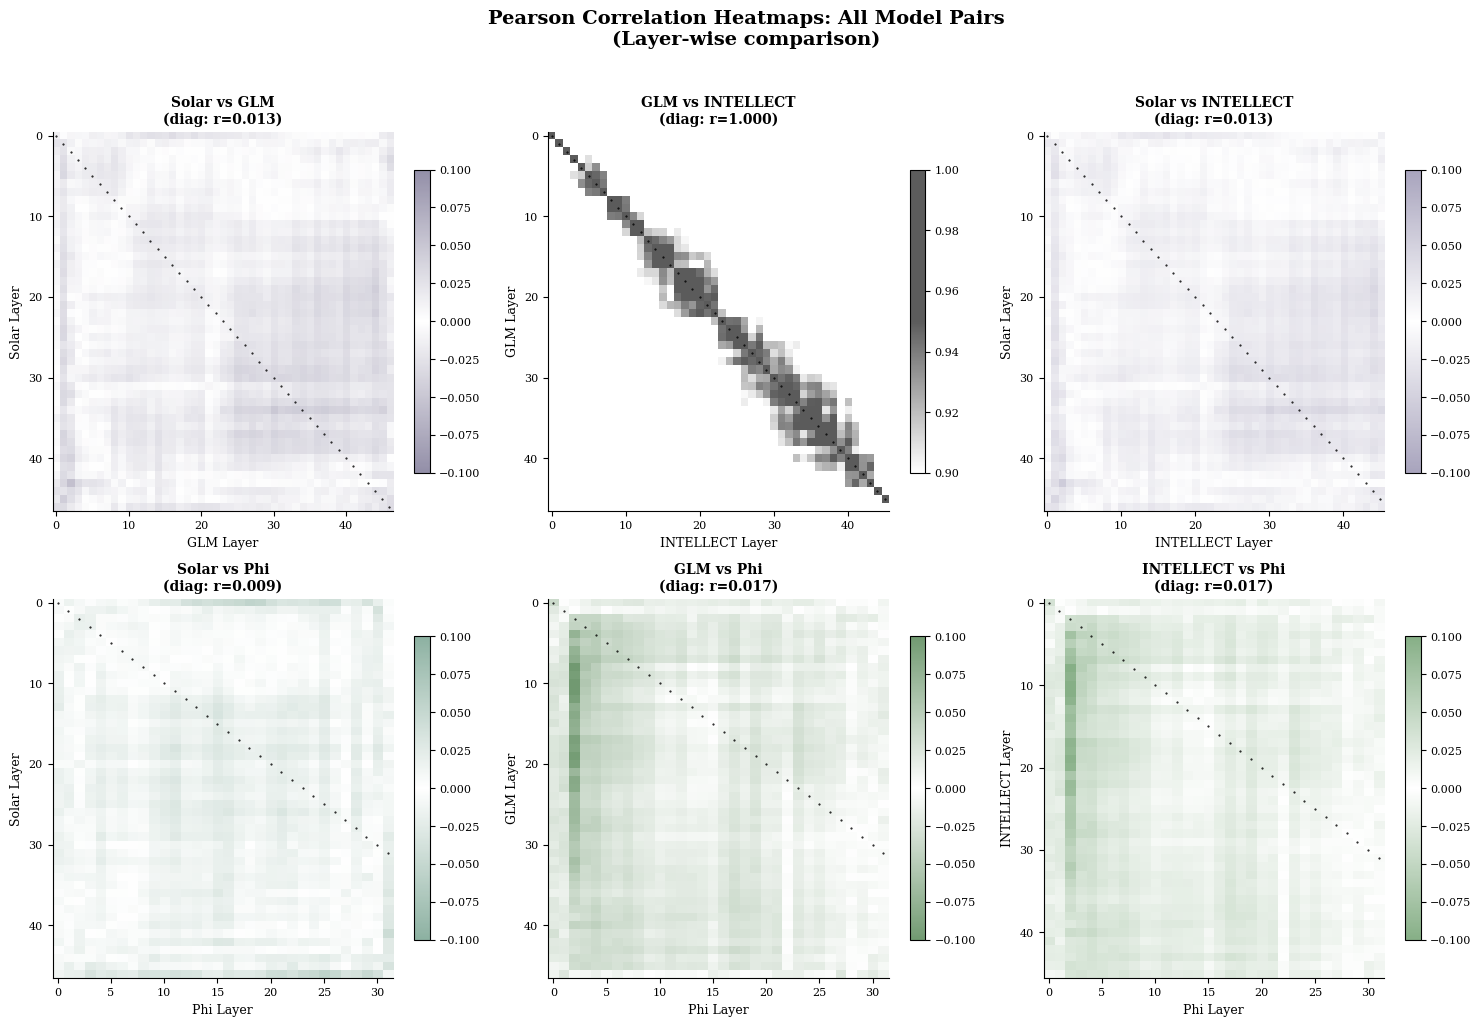

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name_a, name_b) in enumerate(pairs):
    ax = axes[idx]
    matrix = matrices[(name_a, name_b)]
    s = stats[(name_a, name_b)]
    is_derivative = (name_a == 'GLM' and name_b == 'INTELLECT')
    cmap = create_pair_colormap(name_a, name_b, is_derivative)
    vmin, vmax = (0.9, 1.0) if is_derivative else (-0.1, 0.1)
    im = ax.imshow(matrix, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    ax.set_xlabel(f'{name_b} Layer')
    ax.set_ylabel(f'{name_a} Layer')
    ax.set_title(f'{name_a} vs {name_b}\n(diag: r={s["diag_mean"]:.3f})', fontweight='bold')
    plt.colorbar(im, ax=ax, shrink=0.8)
    n_diag = min(matrix.shape[0], matrix.shape[1])
    for i in range(n_diag):
        ax.plot(i, i, 'k.', markersize=1)

fig.suptitle('Pearson Correlation Heatmaps: All Model Pairs\n(Layer-wise comparison)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. Figure 6, 7, 8: Heatmap, PCA, Statistics

In [16]:
model_weights = {}
for name, model_id in MODELS.items():
    w = load_all_layers(model_id, "input")
    if w is not None:
        model_weights[name] = w

solar_w = model_weights.get('Solar')
glm_w = model_weights.get('GLM')
intellect_w = model_weights.get('INTELLECT')
phi_w = model_weights.get('Phi')

n_layers = min(len(solar_w), len(glm_w))
n_dims = min(solar_w.shape[1], glm_w.shape[1])
solar_w = solar_w[:n_layers, :n_dims]
glm_w = glm_w[:n_layers, :n_dims]
if intellect_w is not None:
    intellect_w = intellect_w[:min(len(intellect_w), n_layers), :n_dims]
if phi_w is not None:
    phi_w = phi_w[:min(len(phi_w), n_layers), :min(phi_w.shape[1], n_dims)]

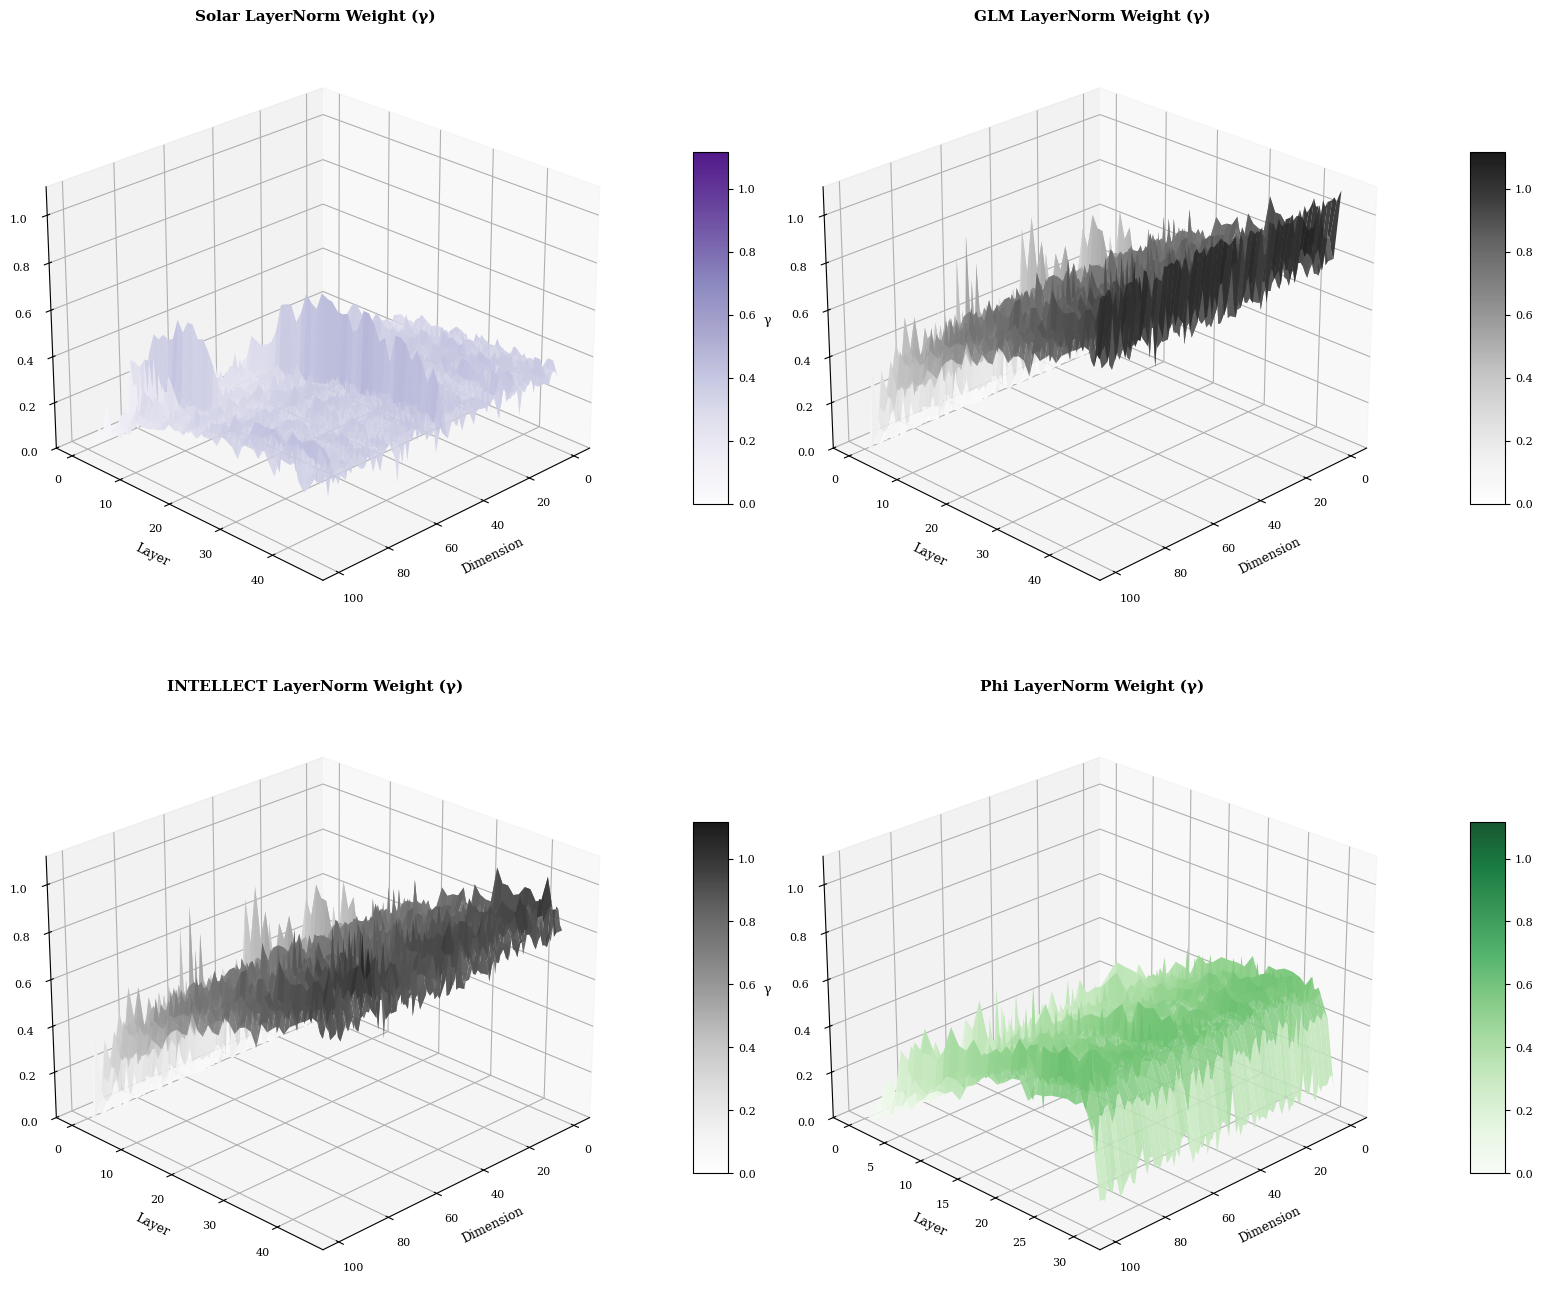

In [17]:
                      
fig = plt.figure(figsize=(16, 14))

surface_models = [('Solar', solar_w, 'Purples'), ('GLM', glm_w, 'Greys')]
if intellect_w is not None:
    surface_models.append(('INTELLECT', intellect_w, 'Greys'))
if phi_w is not None:
    surface_models.append(('Phi', phi_w, 'Greens'))

N_SHOW_DIMS = 100
N_SHOW_LAYERS = min(n_layers, 47)

all_max = max(w[:N_SHOW_LAYERS, :N_SHOW_DIMS].max() for _, w, _ in surface_models)
vmax = min(2.0, all_max)

for idx, (name, weights, cmap) in enumerate(surface_models):
    ax = fig.add_subplot(2, 2, idx + 1, projection='3d')
    n_l = min(N_SHOW_LAYERS, len(weights))
    n_d = min(N_SHOW_DIMS, weights.shape[1])
    weights_sub = weights[:n_l, :n_d]

    X, Y = np.meshgrid(np.arange(n_d), np.arange(n_l))
    surf = ax.plot_surface(X, Y, weights_sub, cmap=cmap, alpha=0.9,
                           edgecolor='none', vmin=0, vmax=vmax)

    ax.set_xlabel('Dimension', fontsize=9)
    ax.set_ylabel('Layer', fontsize=9)
    ax.set_zlabel('γ', fontsize=9)
    ax.set_zlim(0, vmax)
    ax.set_title(f'{name} LayerNorm Weight (γ)', fontweight='bold', fontsize=11)
    ax.view_init(elev=25, azim=45)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

plt.tight_layout()
plt.show()


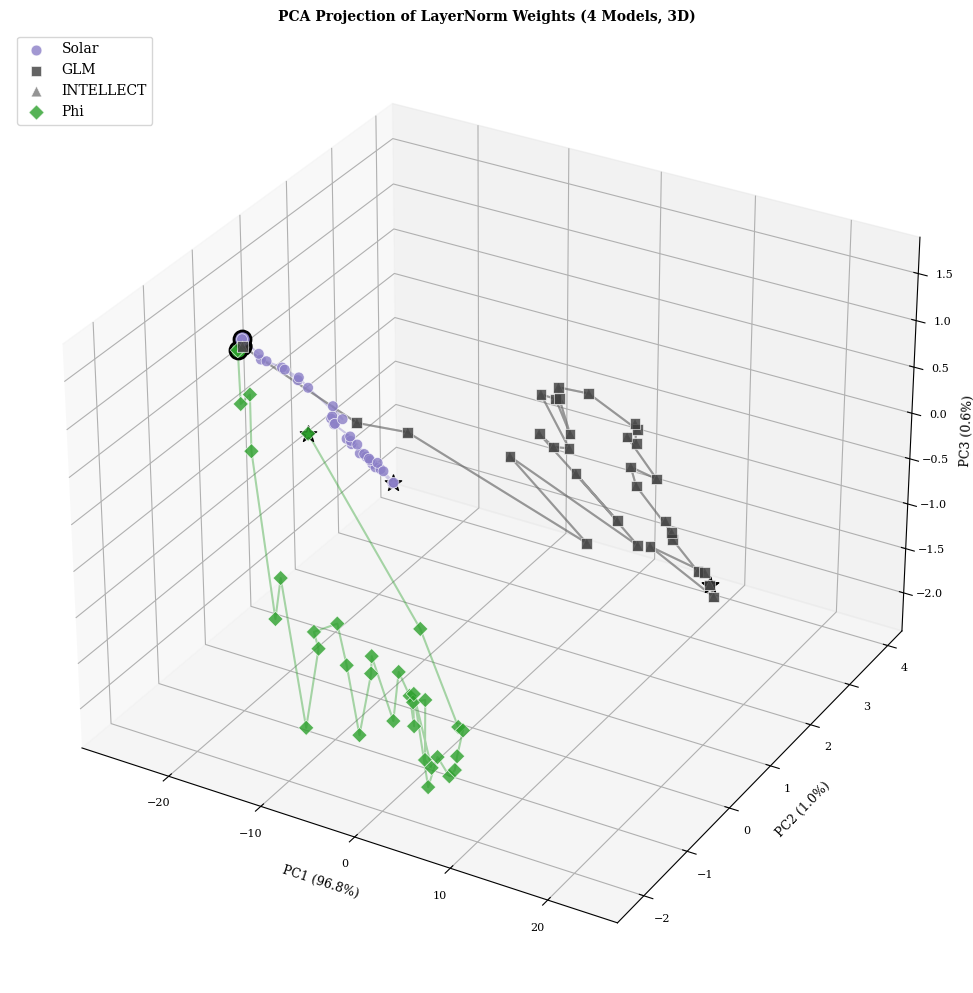

In [18]:
                  
models_for_pca = [('Solar', solar_w), ('GLM', glm_w)]
if intellect_w is not None:
    models_for_pca.append(('INTELLECT', intellect_w))
if phi_w is not None:
    phi_padded = np.zeros((len(phi_w), n_dims))
    phi_padded[:, :phi_w.shape[1]] = phi_w
    models_for_pca.append(('Phi', phi_padded))

min_layers_pca = min(len(w) for _, w in models_for_pca)
combined = np.vstack([w[:min_layers_pca] for _, w in models_for_pca])
pca = PCA(n_components=3)
combined_pca = pca.fit_transform(combined)

pca_results = {}
offset = 0
for name, w in models_for_pca:
    pca_results[name] = combined_pca[offset:offset+min_layers_pca]
    offset += min_layers_pca

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for name, pca_data in pca_results.items():
    ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=COLORS[name], s=60, alpha=0.8,
               edgecolors='white', linewidth=0.5, label=name, marker=MARKERS[name])
    ax.plot(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], '-', color=COLORS[name], alpha=0.4, linewidth=1.5)
    ax.scatter(pca_data[0, 0], pca_data[0, 1], pca_data[0, 2], c=COLORS[name], s=150, marker='o', edgecolors='black', linewidth=2)
    ax.scatter(pca_data[-1, 0], pca_data[-1, 1], pca_data[-1, 2], c=COLORS[name], s=150, marker='*', edgecolors='black', linewidth=1)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title('PCA Projection of LayerNorm Weights (4 Models, 3D)', fontweight='bold')
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

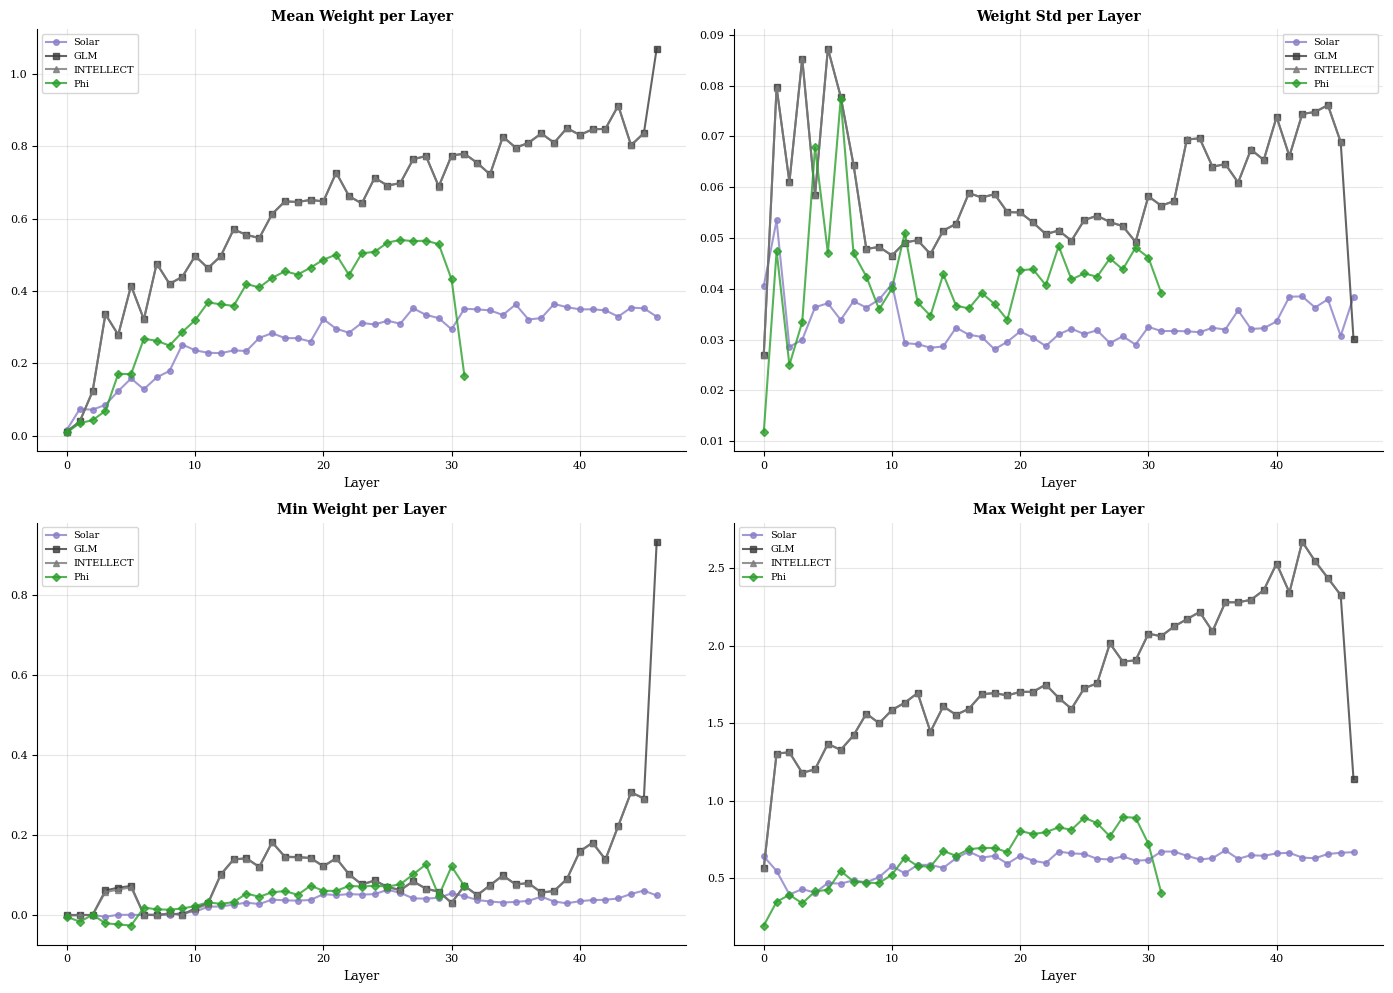

In [19]:
                      
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
models_stats = [('Solar', solar_w), ('GLM', glm_w)]
if intellect_w is not None:
    models_stats.append(('INTELLECT', intellect_w))
if phi_w is not None:
    models_stats.append(('Phi', phi_w))

for ax, stat_fn, title in zip(axes.flatten(),
                               [lambda w: w.mean(axis=1), lambda w: w.std(axis=1),
                                lambda w: w.min(axis=1), lambda w: w.max(axis=1)],
                               ['Mean Weight per Layer', 'Weight Std per Layer',
                                'Min Weight per Layer', 'Max Weight per Layer']):
    for name, weights in models_stats:
        ax.plot(range(len(weights)), stat_fn(weights), f'-{MARKERS[name]}',
                color=COLORS[name], label=name, markersize=4, alpha=0.8)
    ax.set_xlabel('Layer')
    ax.set_title(title, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Figure 9: Ridge Plot

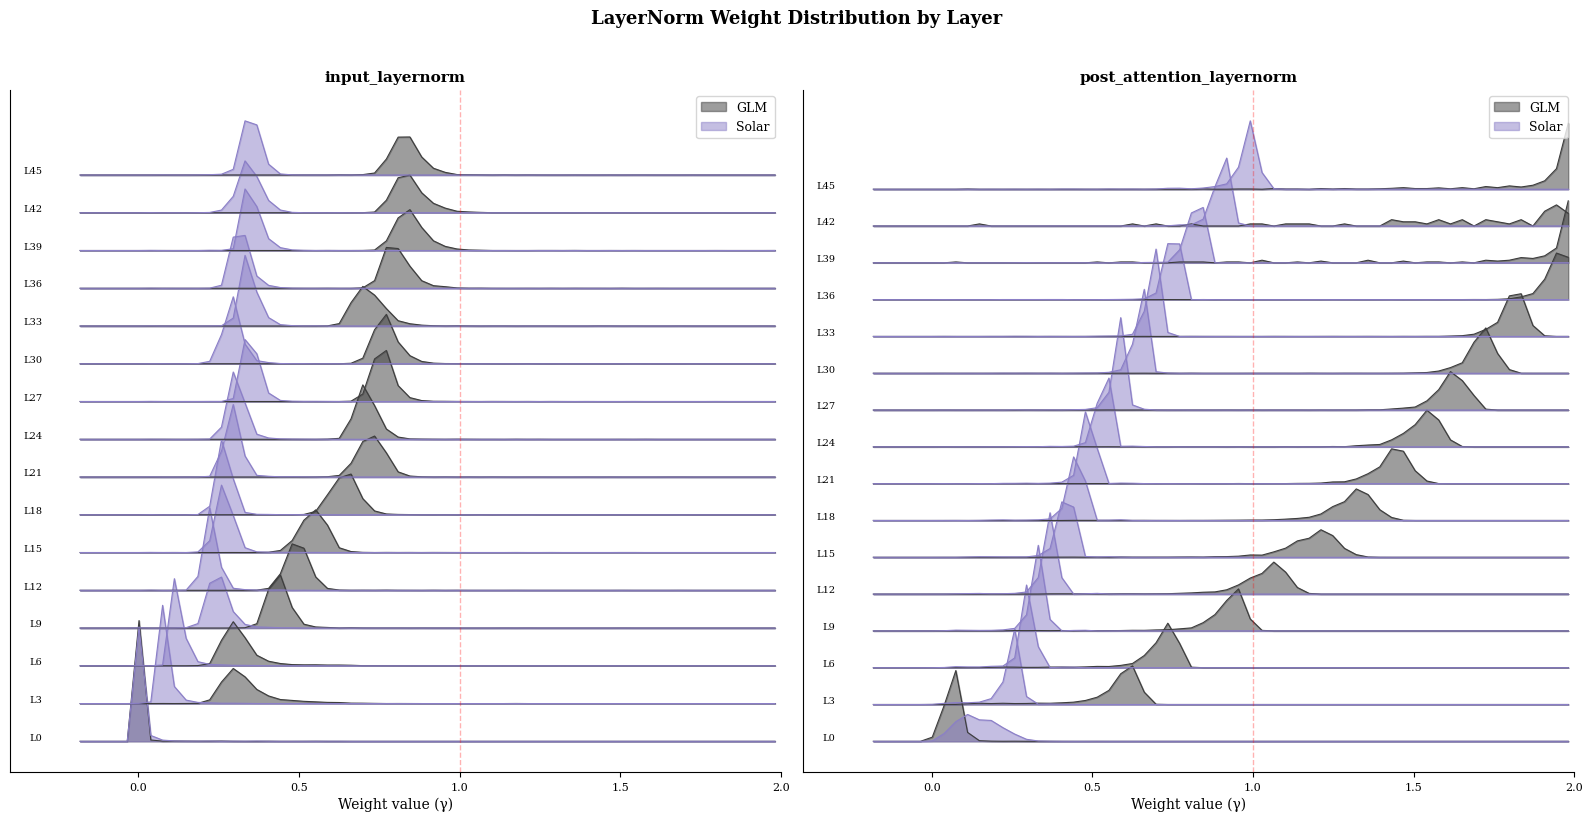

In [20]:
solar_input = load_all_layers(MODELS['Solar'], "input")
solar_post = load_all_layers(MODELS['Solar'], "post")
glm_input = load_all_layers(MODELS['GLM'], "input")
glm_post = load_all_layers(MODELS['GLM'], "post")

n_layers = min(len(solar_input), len(glm_input))
sample_layers = list(range(0, n_layers, 3))

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for ax, (solar_w, glm_w, title) in zip(axes, [
    (solar_input, glm_input, 'input_layernorm'),
    (solar_post, glm_post, 'post_attention_layernorm')
]):
    for i, layer_idx in enumerate(sample_layers):
        offset = i * 1.0
        solar_hist, solar_bins = np.histogram(solar_w[layer_idx], bins=60, range=(-0.2, 2.0), density=True)
        solar_centers = (solar_bins[:-1] + solar_bins[1:]) / 2
        glm_hist, glm_bins = np.histogram(glm_w[layer_idx], bins=60, range=(-0.2, 2.0), density=True)
        glm_centers = (glm_bins[:-1] + glm_bins[1:]) / 2
        scale = 0.12

        ax.fill_between(glm_centers, offset, offset + glm_hist * scale, alpha=0.5, color=COLORS['GLM'], label='GLM' if i == 0 else '')
        ax.plot(glm_centers, offset + glm_hist * scale, color=COLORS['GLM'], linewidth=0.8)
        ax.fill_between(solar_centers, offset, offset + solar_hist * scale, alpha=0.5, color=COLORS['Solar'], label='Solar' if i == 0 else '')
        ax.plot(solar_centers, offset + solar_hist * scale, color=COLORS['Solar'], linewidth=0.8)
        ax.text(-0.3, offset + 0.1, f'L{layer_idx}', fontsize=7, ha='right', va='center')

    ax.set_xlabel('Weight value (γ)', fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlim(-0.4, 2.0)
    ax.set_yticks([])
    ax.legend(loc='upper right', fontsize=9)
    ax.axvline(x=1.0, color='red', linestyle='--', linewidth=1, alpha=0.3)

plt.suptitle('LayerNorm Weight Distribution by Layer', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Figure 10: Within-layer input vs post analysis (inline)
solar_id = MODELS['Solar']
glm_id = MODELS['GLM']
max_layer = 46

means_fig10 = {"Solar": [], "GLM": []}
stds_fig10 = {"Solar": [], "GLM": []}
corrs_fig10 = []
layers_fig10 = []

for layer in range(max_layer + 1):
    solar_in = load_layernorm_weight(solar_id, layer, "input")
    solar_post = load_layernorm_weight(solar_id, layer, "post")
    glm_in = load_layernorm_weight(glm_id, layer, "input")
    glm_post = load_layernorm_weight(glm_id, layer, "post")
    
    if any(x is None for x in (solar_in, solar_post, glm_in, glm_post)):
        continue
    if solar_in.shape != solar_post.shape or glm_in.shape != glm_post.shape:
        continue
    
    solar_diff = solar_in - solar_post
    glm_diff = glm_in - glm_post
    
    means_fig10["Solar"].append(solar_diff.mean())
    means_fig10["GLM"].append(glm_diff.mean())
    stds_fig10["Solar"].append(solar_diff.std())
    stds_fig10["GLM"].append(glm_diff.std())
    corrs_fig10.append(pearson_correlation(solar_diff, glm_diff))
    layers_fig10.append(layer)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax1 = axes[0]
ax1.plot(layers_fig10, means_fig10["Solar"], "-o", color="#8B7FC7", markersize=3, label="Solar")
ax1.plot(layers_fig10, means_fig10["GLM"], "-s", color="#4a4a4a", markersize=3, label="GLM")
ax1.set_title("(a) Mean (input - post)", fontweight="bold")
ax1.set_xlabel("Layer")
ax1.set_ylabel("Mean")
ax1.axhline(0, color="gray", linewidth=0.8, alpha=0.5)
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2 = axes[1]
ax2.plot(layers_fig10, stds_fig10["Solar"], "-o", color="#8B7FC7", markersize=3, label="Solar")
ax2.plot(layers_fig10, stds_fig10["GLM"], "-s", color="#4a4a4a", markersize=3, label="GLM")
ax2.set_title("(b) Std (input - post)", fontweight="bold")
ax2.set_xlabel("Layer")
ax2.set_ylabel("Std")
ax2.grid(True, alpha=0.3)
ax2.legend()

ax3 = axes[2]
ax3.plot(layers_fig10, corrs_fig10, "-^", color="#5e3c99", markersize=3)
ax3.set_title("(c) Pearson (Solar vs GLM)", fontweight="bold")
ax3.set_xlabel("Layer")
ax3.set_ylabel("Pearson r")
ax3.axhline(0, color="gray", linewidth=0.8, alpha=0.5)
ax3.set_ylim(-0.2, 0.2)
ax3.grid(True, alpha=0.3)

fig.suptitle("Within-Layer Analysis: input_LN vs post_LN", fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## Script Runs (Figure Order)


In [22]:
!python scripts/figure_00_cosine_animation_3d.py


Saved: result/figure_00_cosine_before_3d.png


Saved: result/figure_00_cosine_after_3d.png
Generating 3D animation...


Saved: result/figure_00_cosine_bias_animation_3d.gif


In [23]:
!python scripts/figure_01_03_04_intuition_all.py


In [24]:
!python scripts/figure_02_heatmap.py


In [25]:
!python scripts/figure_03_1_glm_intellect_diff.py


In [26]:
!python scripts/figure_05_multi_heatmap.py


In [27]:
!python scripts/figure_06_07_08_layernorm_viz.py


In [28]:
!python scripts/figure_09_ridge_overlay.py


In [29]:
!python scripts/figure_10_input_vs_post_within_layer.py
